In [1]:
import numpy as np 
import pandas as pd 
import time, warnings
import datetime as dt

#visualization library
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns
import squarify

warnings.filterwarnings("ignore")

In [2]:
retail_df = pd.read_csv('Denormalization.csv',encoding="ISO-8859-1")
retail_df.head()

,customer_id,customer_first_name,customer_last_name,order_key,order_date,order_priority,sales,quantity,discount,profit,shipping_cost,product_key,category,sub_category,product_name
0,1,Sample,A,3,2014-03-06,Medium,17.460,1,0.0,0.510,0.81,1,Office Supplies,Storage,"Eldon Folders, Industrial"
1,462,Lisa,Ryan,575,2014-02-21,High,69.840,4,0.0,2.040,7.78,1,Office Supplies,Storage,"Eldon Folders, Industrial"
2,409,Mary,Zewe,1093,2012-07-30,Medium,34.920,2,0.0,1.020,1.92,1,Office Supplies,Storage,"Eldon Folders, Industrial"
3,409,Mary,Zewe,1150,2012-07-30,Medium,34.920,2,0.0,1.020,1.92,1,Office Supplies,Storage,"Eldon Folders, Industrial"
4,546,Cynthia,Delaney,9507,2011-11-01,High,6.984,1,0.6,-9.966,1.23,1,Office Supplies,Storage,"Eldon Folders, Industrial"


The RFM model is straightforward and easy to understand for people without technical background. 
Each customer is assigned a score based on their shopping behavior. On a scale of 1 to 4, rate the customer based on how frequent they shop at global superstore, how much money they spend at global superstore, and how much time has elapsed since customer’s last purchase.

## Recency

How much time has elapsed since the customer's last purchase

In [3]:
# find the most recent customer purchase date
retail_df['order_date'].max()

'2014-12-31'

In [4]:
# convert order date to datetime.date format
retail_df['order_date'] = pd.DatetimeIndex(retail_df['order_date']).date

In [5]:
# set today date be 2015/01/01 in datetime.date format
now = dt.date(2015,1,1)
print(now)

2015-01-01


In [6]:
#group by customers and check last date of purshace
# as_index = False avoid using customer_id as index and automatically creates a new index column
recency_df = retail_df.groupby(by='customer_id', as_index=False)['order_date'].max()
recency_df.columns = ['customer_id','LastPurshaceDate']
recency_df.head()

,customer_id,LastPurshaceDate
0,1,2014-11-21
1,2,2014-12-12
2,3,2014-12-04
3,4,2014-05-15
4,5,2014-01-08


In [7]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)
recency_df.head()

,customer_id,LastPurshaceDate,Recency
0,1,2014-11-21,41
1,2,2014-12-12,20
2,3,2014-12-04,28
3,4,2014-05-15,231
4,5,2014-01-08,358


In [8]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

## Frequency

How many times the customer place an order

In [9]:
#calculate the number of purchases for each customer
frequency_df = retail_df.groupby(by=['customer_id'], as_index=False)['order_key'].count()
frequency_df.columns = ['customer_id','Frequency']
frequency_df.head()

,customer_id,Frequency
0,1,94
1,2,41
2,3,17
3,4,2
4,5,2


In [10]:
frequency_df.shape

(506, 2)

## Monetary

How much money customer spend altogether

In [11]:
# calculate the sum of sales for each customer
monetary_df = retail_df.groupby(by=['customer_id'], as_index=False).agg({'sales': 'sum'})
monetary_df.columns = ['customer_id','Monetary']
monetary_df.head()

,customer_id,Monetary
0,1,20383.27302
1,2,5672.56500
2,3,1698.38000
3,4,1362.06000
4,5,30.77000


## Create RFM Table

In [12]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='customer_id')
temp_df.head()

,customer_id,Recency,Frequency
0,1,41,94
1,2,20,41
2,3,28,17
3,4,231,2
4,5,358,2


In [13]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='customer_id')
#use CustomerID as index
rfm_df.set_index('customer_id',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
customer_id,,,
1,41,94,20383.27302
2,20,41,5672.56500
3,28,17,1698.38000
4,231,2,1362.06000
5,358,2,30.77000


# Create Customer Segmentation with RFM Model

## RFM Quantile

In [14]:
# use quantile function to segment the data to 4 parts, find the first, second, thrid quartile
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,149.00,1.0,44.7030
0.50,379.00,1.0,116.6700
0.75,754.75,2.0,360.5475


In [15]:
# convert the quantile to dictionary
quantiles.to_dict()

{'Recency': {0.25: 149.0, 0.5: 379.0, 0.75: 754.75},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'Monetary': {0.25: 44.703, 0.5: 116.67, 0.75: 360.5475}}

## Creation of RFM Segments

In [16]:
# We will create two segmentation classes since, high recency is bad, 
# while high frequency and monetary value is good.

In [17]:
# Arguments (x = value, p = recency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [18]:
#create rfm segmentation dataframe
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))
rfm_segmentation['RFM_Sum'] = rfm_segmentation[['R_Quartile','F_Quartile','M_Quartile']].sum(axis=1)

In [19]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFM_Sum
customer_id,,,,,,,
1,41,94,20383.27302,4,4,4,12
2,20,41,5672.56500,4,4,4,12
3,28,17,1698.38000,4,4,4,12
4,231,2,1362.06000,3,3,4,10
5,358,2,30.77000,3,3,1,7


In [20]:
rfm_segmentation['RFM_Score'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFM_Sum,RFM_Score
customer_id,,,,,,,,
1,41,94,20383.27302,4,4,4,12,444
2,20,41,5672.56500,4,4,4,12,444
3,28,17,1698.38000,4,4,4,12,444
4,231,2,1362.06000,3,3,4,10,334
5,358,2,30.77000,3,3,1,7,331


In [21]:
rfm_segmentation[rfm_segmentation['RFM_Score']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFM_Sum,RFM_Score
customer_id,,,,,,,,
1,41,94,20383.27302,4,4,4,12,444
2,20,41,5672.56500,4,4,4,12,444
355,132,3,3927.63000,4,4,4,12,444
795,40,3,2895.06000,4,4,4,12,444
3,28,17,1698.38000,4,4,4,12,444
649,132,3,928.69800,4,4,4,12,444
647,59,3,926.39400,4,4,4,12,444
185,106,4,879.86800,4,4,4,12,444
301,97,3,831.73912,4,4,4,12,444


### Define Customer Segment based on RFM_sum

In [82]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Sum'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Sum'] == 8)):
        return 'Champions'
    elif ((df['RFM_Sum'] == 7)):
        return 'Loyal'
    elif ((df['RFM_Sum'] == 6)):
        return 'Potential'
    elif ((df['RFM_Sum'] == 5)):
        return 'Promising'
    elif ((df['RFM_Sum'] == 4)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm_segmentation['RFM_Level'] = rfm_segmentation.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFM_Sum,RFM_Score,RFM_Level
customer_id,,,,,,,,,
1,41,94,20383.27302,4,4,4,12,444,Can't Loose Them
2,20,41,5672.56500,4,4,4,12,444,Can't Loose Them
3,28,17,1698.38000,4,4,4,12,444,Can't Loose Them
4,231,2,1362.06000,3,3,4,10,334,Can't Loose Them
5,358,2,30.77000,3,3,1,7,331,Loyal


In [83]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm_segmentation.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
rfm_level_agg.columns = ['recencymean','frequencymean','monetarymean', 'count']
# Print the aggregated dataset
print(rfm_level_agg)

                    recencymean  frequencymean  monetarymean  count
RFM_Level                                                          
Can't Loose Them          227.7            3.4         785.2    166
Champions                 394.8            1.8         335.8     63
Loyal                     393.3            1.5         265.9     54
Needs Attention           781.7            1.0          48.5     55
Potential                 541.4            1.1         268.1     68
Promising                 581.7            1.0          74.9     63
Require Activation       1050.6            1.0          18.2     37


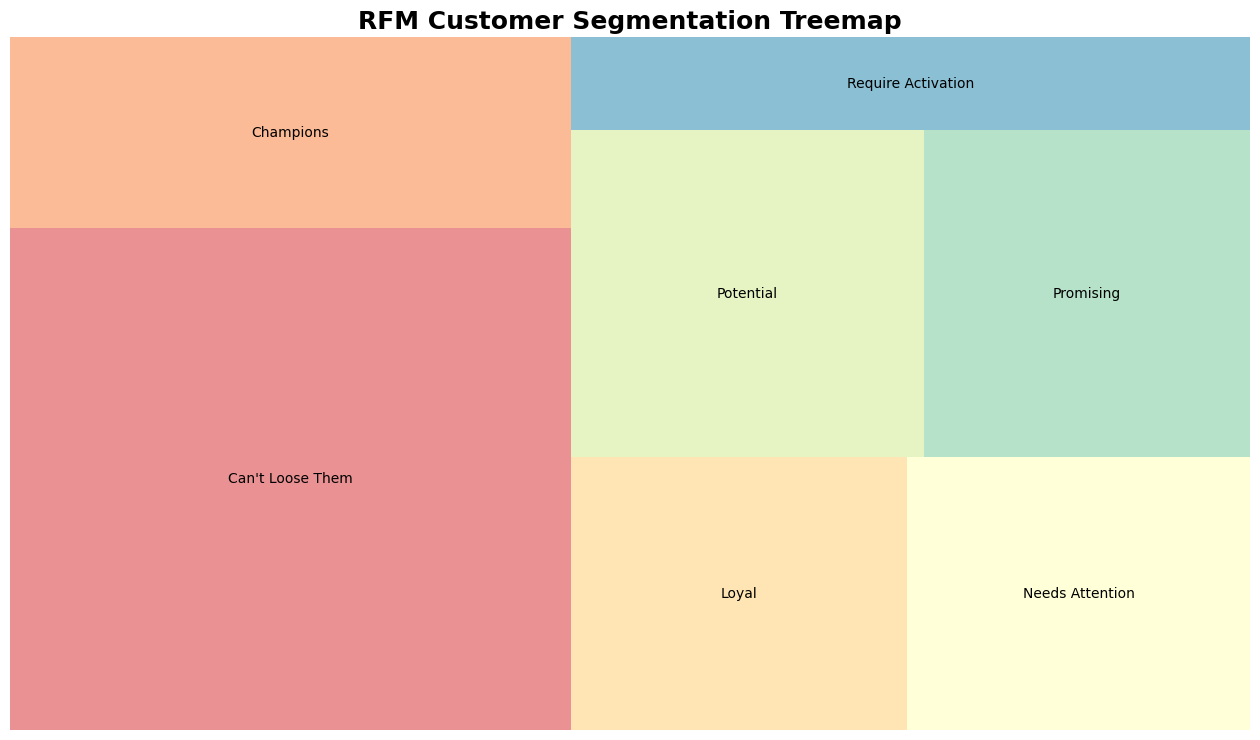

In [84]:
#Create the RFM customer segmentation treemap
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], 
              alpha=.6, 
              color=sns.color_palette("Spectral", len(rfm_level_agg['count'])))
plt.title("RFM Customer Segmentation Treemap",fontsize=18,fontweight="bold")
plt.axis('off');

### Define Customer Segment based on RFM_Score

In [26]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFM_Score']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFM_Score']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFM_Score']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFM_Score']=='111']))

Best Customers:  21
Loyal Customers:  80
Big Spenders:  127
Almost Lost:  7
Lost Customers:  4
Lost Cheap Customers:  37


## Create Function to get the customer segment 

In [93]:
# Here we tend to find customers who have spent most money and have shopped most times. (F = 4 and M = 4)
# If this customer is also having a high recency level, then he is our best customer (4,4,4)
# If this customer is not having a high recency level(like 1 or 2), then we need to find out ways to keep this customer.
def get_score(customer_id):
    R_Quantile = rfm_segmentation.loc[customer_id].R_Quartile
    F_Quartile = rfm_segmentation.loc[customer_id].F_Quartile
    M_Quartile = rfm_segmentation.loc[customer_id].M_Quartile
    if R_Quantile == 4 & F_Quartile == 4 & M_Quartile == 4:
        print('customer {id} belongs to Best Customer group'.format(id = customer_id))
    if R_Quantile == 2 & F_Quartile == 4 & M_Quartile == 4:
        print('customer {id} belongs to Almost Lost group, we need to keep him!'.format(id = customer_id))
    if R_Quantile == 1 & F_Quartile == 4 & M_Quartile == 4:
        print('customer {id} belongs to Lost customer group'.format(id = customer_id))       

In [94]:
# Example of segmenting a customer to its group
get_score(1)

customer 1 belongs to Best Customer group


In [88]:
def get_score2(customer_id):
    RFM_Sum = rfm_segmentation.loc[customer_id].RFM_Sum
    if RFM_Sum >= 9:
        print('customer {id} belongs to Can\'t Loose Them group'.format(id = customer_id))
    if RFM_Sum == 8:
        print('customer {id} belongs to Champions group'.format(id = customer_id))
    if RFM_Sum == 7:
        print('customer {id} belongs to Loyal group'.format(id = customer_id))
    if RFM_Sum == 6:
        print('customer {id} belongs to Potential group'.format(id = customer_id))
    if RFM_Sum == 5:
        print('customer {id} belongs to Promising group'.format(id = customer_id))
    if RFM_Sum == 4:
        print('customer {id} belongs to Needs Attention group'.format(id = customer_id))
    if RFM_Sum < 4:
        print('customer {id} belongs to Requires Activation group'.format(id = customer_id))

In [92]:
get_score2(1)

customer 1 belongs to Can't Loose Them group


This rule-based algorithm is easy to change the rules and quickly returns the customer segments where marketing team can develop targeted strategies to high value customers to increase profitability. It also helps to understand the customer base and increase the customer retention rate.  
